# **[Real or Fake] Fake JobPosting Prediction**

This dataset contains 18k job description entries out of which 800 are fake and rest are real. The description for each job contains both categorical and numerical values and based on this, the idea is to create a classifier to identify fraudulent job postings.

As this is a starting project, here I will first implement a simple logistic regression, then extend it to a multi layered deep learning architecture. The idea is to implement the neural network from scratch without implementing any of the pre-existing frameworks. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving fake_job_postings.csv to fake_job_postings.csv


In [ ]:
df = pd.read_csv('fake_job_postings.csv')

## **Data Understanding**

As stated earlier, there are around 18k data points, with 18 describing elements for each job.

In [ ]:
df.shape

(17880, 18)

The data is combination of both numerical and categorical features. The target is in the last column *'fraudulent'*.

In [ ]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


The numerical values in the dataset are all binary.

In [ ]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


We can see below that the dataset contains a lot of null values, but exclusively in the categorical part.

In [ ]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

Likewise, as we can see that approximately 95% of the data is false. This is a imbalanced dataset. So solve this problem we can resample. There are two methods: oversampling the minority class or undersampling the majority class. To oversample, we need to generate synthetic data, which might then complicate the problem due to the problem of overfitting towards certain generated tendencies. Here, we just undersample to match the number of classes in the training set.


In [ ]:
df['fraudulent'].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

The way the description is written is can be an important factor for fraud detection. However, we need language processing in order to achieve that. In our case we do not consider this problem, and just take into consideration other factors.

## **Data Analysis:**

Rather than going into the advertisement text analysis (which is planned using RNN in the later project), here we will mostly look into other extrapolative features resulting from the description.

For location, we can see that there the data is filled in with the format "country, state, city". So we can split the column into three separate entities.

In [ ]:
df['country'] = df['location'].str.split(',', expand=True)[0]
df['state'] = df['location'].str.split(',', expand=True)[2]
df['city'] = df['location'].str.split(',', expand=True)[1]

For the features "company_profile, salary_range, required_experience and required_education", we will consider whether the fields are present of not as we do not want to go into NLP for this task.

In [ ]:
df['has_company_profile'] = df['company_profile'].isnull().astype(int)
df['has_salary_range'] = df['salary_range'].isnull().astype(int)
df['has_required_experience'] = df['required_experience'].isnull().astype(int)
df['has_required_education'] = df['required_education'].isnull().astype(int)

As you can see below, the presence of the field does indicate real or fraudulent job posting to some extent.

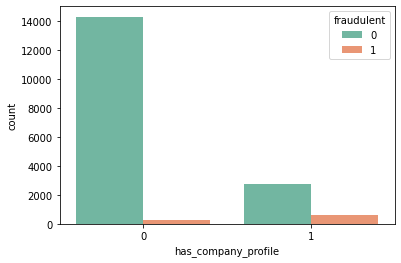

In [ ]:
sns.countplot(x=df['has_company_profile'], data=df, hue='fraudulent', palette='Set2') 

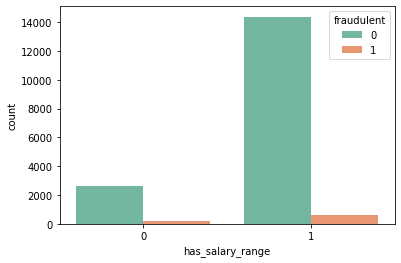

In [ ]:
sns.countplot(x=df['has_salary_range'], data=df, hue='fraudulent', palette='Set2') 

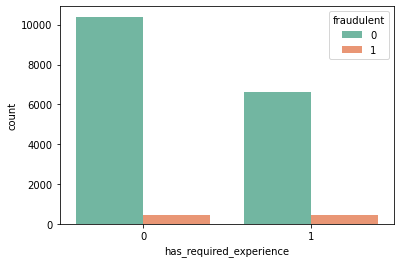

In [ ]:
sns.countplot(x=df['has_required_experience'], data=df, hue='fraudulent', palette='Set2') 

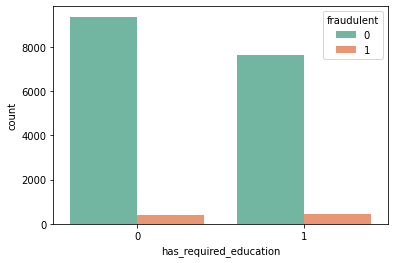

In [ ]:
sns.countplot(x=df['has_required_education'], data=df, hue='fraudulent', palette='Set2') 

### **Data Preprocessing:**

### **Balance the data:**

As stated earlier, since the data is imbalanced, we undersample so that we pick the data for non fraudulent advertisements to be equal to the fraudulent ones.

In [ ]:
df_sampled_0 = df[df['fraudulent']==0].sample(n = 866)

In [ ]:
df_sampled = pd.concat([df_sampled_0, df[df['fraudulent']==1]]).sample(frac=1).reset_index(drop=True)

In [ ]:
df_sampled['fraudulent'].value_counts()

1    866
0    866
Name: fraudulent, dtype: int64

The balanced data gives a better intuitive insight into the four additional fields we created in the data analysis section.

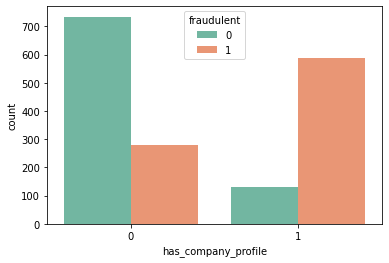

In [ ]:
sns.countplot(x=df_sampled['has_company_profile'], data=df_sampled, hue='fraudulent', palette='Set2') 

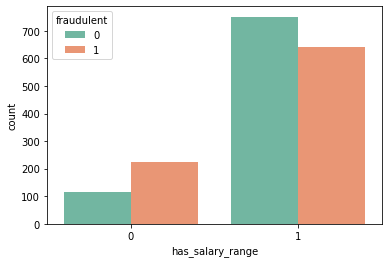

In [ ]:
sns.countplot(x=df_sampled['has_salary_range'], data=df_sampled, hue='fraudulent', palette='Set2') 

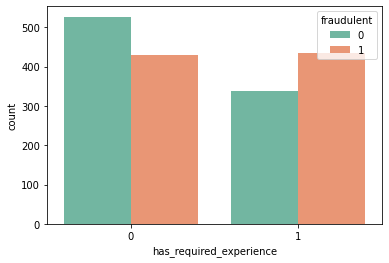

In [ ]:
sns.countplot(x=df_sampled['has_required_experience'], data=df_sampled, hue='fraudulent', palette='Set2') 

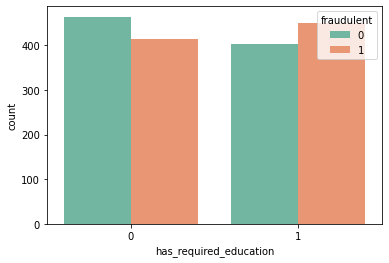

In [ ]:
sns.countplot(x=df_sampled['has_required_education'], data=df_sampled, hue='fraudulent', palette='Set2') 

### **Drop unnecessary labels:**

In [ ]:
df_sampled.drop(['job_id', 'location', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits'], axis=1, inplace=True)

Since a lot of fields in the categorical columns are null, we replace all of them by a token and use the absence of information as another feature. 

In [ ]:
df_sampled.fillna('<UNK>', inplace=True)

In [ ]:
df_sampled

,title,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state,city,has_company_profile,has_salary_range,has_required_experience,has_required_education
0,Data Entry Clerk / Administrative Assistant,Administrative,0,0,0,Full-time,Entry level,Bachelor's Degree,Telecommunications,Administrative,1,US,Washington,DC,1,0,0,0
1,Data and Marketing Analyst,<UNK>,0,1,1,Full-time,Entry level,Master's Degree,Information Technology and Services,Data Analyst,0,NO,,03,0,1,0,0
2,Marketing Manager,<UNK>,0,1,0,Full-time,Mid-Senior level,<UNK>,Information Technology and Services,<UNK>,0,PL,Warszawa,MZ,0,1,0,1
3,Restaurant Manager - Le Meridien KL,<UNK>,0,1,0,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,1,MY,,,0,1,1,1
4,English Teacher Abroad,<UNK>,0,1,1,Contract,<UNK>,Bachelor's Degree,Education Management,<UNK>,0,US,Saratoga Springs,NY,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1727,"Account Sales Managers $80-$130,000/yr",<UNK>,0,1,0,Full-time,Associate,High School or equivalent,Financial Services,Business Development,1,US,Long Island,NY,0,1,0,0
1728,KMC,<UNK>,0,0,0,<UNK>,<UNK>,<UNK>,<UNK>,<UNK>,1,<UNK>,<UNK>,<UNK>,1,1,1,1
1729,Sales & Marketing Assistant,<UNK>,0,1,0,Full-time,Associate,<UNK>,Retail,Marketing,0,GR,Athens,I,0,1,0,1
1730,RNFA Registered Nurse First Assistant,<UNK>,0,0,0,Part-time,<UNK>,<UNK>,Hospital & Health Care,<UNK>,1,US,,OH,1,1,1,1


### **One Hot Encode:**

It is important to one hot encode the values, as all the values should be tokenized into some numerical values. We could potentially just tokenize with different numbers, however, the algorithm can mistake the values of different integer tokens to be their weight. So, one hot encoding, even though it creates a large sparse matrix, is preferred.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
 

columns_to_encode =  ['title', 'department', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'country', 'state', 'city']
ohe    = OneHotEncoder(sparse=False)
encoded_columns =    ohe.fit_transform(df_sampled[columns_to_encode])
encoded_df = pd.DataFrame(encoded_columns)
ohe.get_feature_names()
encoded_df.columns = ohe.get_feature_names()



In [ ]:
ohe.get_params()

{'categories': 'auto',
 'drop': None,
 'dtype': numpy.float64,
 'handle_unknown': 'error',
 'sparse': False}

Here, we have the encoded dataframe consisting of the one hot values for the categorical fields.

In [ ]:
encoded_df.head()

,x0_ Environmental Technician I,x0_ Piping Material Engineer,"x0_ Discipline Manager Civil, Structural, Marine, Architectural",x0_ FEA Senior engineer,x0_ Manager of Project Management Organization - Engineering,x0_ Mechanical Engineering Manager,"x0_ Resources Change Management, Process Excellence and Change Enablement Manager",x0_ Accounting Clerk,x0_ Accounting/Bookkeeping,x0_ CAD Operator,x0_ CNC Programmer,x0_ Co-Superstar (Asst. Store Manager) - St. Louis Galleria,x0_ Customer Analytics Specialist,x0_ Customer Care Representative I,x0_ Data Entry Representative,x0_ Digital Brand Architects Community Manager,x0_ Drilling Engineer - Exploration,x0_ Hiring for Business Intelligence and Analytics Project Manager,x0_ JOB VACANCIES AT MONTCALM LUXURY HOTEL LONDON.,x0_ Jr. Business Analyst & Quality Analyst (entry level),x0_ MAIL CLERK,x0_ Medical Intake Representative (Data Entry),x0_ Onshore Scaffolding Coordinator,x0_ Payroll Data Entry Clerk Position - Earn $100-$200 Daily,x0_ Production Technician 1781,x0_ SENIOR CORPORATE RECCRUITER,x0_ Sr. Process Engineer,x0_ iSeries Team Lead,x0_(Senior) Structural Engineer,x0_(Work from Home) $20/hr,x0_. Net Developers,x0_.NET Web Developer,x0_.NET developer,x0_.Net developer,x0_2015 Undergrad- Account Management Associate,x0_3D Artist,x0_3D Audio Engineer,x0_5 Guys,x0_ADF Operator II,x0_ADMINISTRATIVE & OFFICE ASSISTANT,...,x9_ NH,x9_ NJ,x9_ NM,x9_ NS,x9_ NSW,x9_ NV,x9_ NY,x9_ NYK,x9_ OH,x9_ OK,x9_ OL,x9_ ON,x9_ OR,x9_ PA,x9_ PKN,x9_ QC,x9_ QLD,x9_ RI,x9_ RIC,x9_ RJ,x9_ SC,x9_ SD,x9_ SHF,x9_ SP,x9_ TA,x9_ TN,x9_ TPQ,x9_ TX,x9_ UT,x9_ VA,x9_ VC,x9_ VIC,x9_ VOV,x9_ WA,x9_ WC,x9_ WGN,x9_ WI,x9_ WSX,x9_ WV,x9_<UNK>
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can now drop the categorical feature columns which we encoded.

In [ ]:
df_sampled_mod = df_sampled.drop(labels = columns_to_encode, axis=1)

In [ ]:
df_sampled_mod

,telecommuting,has_company_logo,has_questions,fraudulent,has_company_profile,has_salary_range,has_required_experience,has_required_education
0,0,0,0,1,1,0,0,0
1,0,1,1,0,0,1,0,0
2,0,1,0,0,0,1,0,1
3,0,1,0,1,0,1,1,1
4,0,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...
1727,0,1,0,1,0,1,0,0
1728,0,0,0,1,1,1,1,1
1729,0,1,0,0,0,1,0,1
1730,0,0,0,1,1,1,1,1


In [ ]:
df_final = pd.concat([df_sampled_mod, encoded_df], axis=1)

Finally, we have our features X and target y.

In [ ]:
X = df_final.loc[:, df_final.columns != 'fraudulent']

In [ ]:
y = df_final['fraudulent']

### **Split training and test data:**

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


In [ ]:
X_train_flat = X_train.values.T
X_test_flat = X_test.values.T

In [ ]:
y_train_flat = y_train.values.reshape(1, -1)
y_test_flat = y_test.values.reshape(1, -1)

In [ ]:
X_train_flat.shape, y_train_flat.shape

((2477, 1212), (1, 1212))

## **Logistic regression using Neural Networks**

As a first step, we will be doing a simple one layer neural network with logistic activation. This essentially resolves to logistic regression. All the features are connected to a single node which outputs the final prediction whether the advertisement is real or fake.

In [ ]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

We initialize the weight and bias vectors. The weight vectors are initialized to gaussian random variables whereas the bias vector is initialized to zero.

In [ ]:
def initialize(n):
  w = np.random.randn(n,1) + np.sqrt(2/(2478))
  b = 0
  return w, b

We then have the propagate function for both the forward and backward propagation step of the neural network for training.

For the forward propagation, the function takes w, b and X as input. The activation function after the propagation through the sigmoid unit is given by A. Here, we have vectorized the operation, meaning that all the m training examples are propagated at the same time, saving operation time and complexity.

Then the function calculates total cost, which we have defined here as binary cross-entropy. It essentially calculates the log likelihood of prediction being correct during the training phase.

Then there is the backward propagation step. For this we need to calculate the derivatives of the cost with respect to A, Z, w and b. These four derivatives are represented by dA, dZ, dw and db respectively.

In [ ]:
def propagate(w, b, X, y):
  A = sigmoid(np.dot(w.T, X) + b)   
  cost = (-1/X.shape[1]) * np.sum(y * np.log(A) + (1-y)* np.log(1-A))
  dA = -y/A - (1-y)/(1-A)
  dZ = A - y
  dw = np.dot(X, dZ.T) * (1. / X.shape[1])
  db = np.sum(A - y) * (1. / X.shape[1])

  grads = {"dw": dw, "db": db}
  return grads, cost

Now, the idea is to perform the optimization step. This function takes number of iterations and learning rate as hyperparameters. 

For each iteration, this function performs one step of the forward and backward propagation step and then updates the weights respectively.  

In [ ]:
def optimization(w, b, X, y, num_iterations, learning_rate):

  costs = []

  for i in range(num_iterations):
    grads, cost = propagate(w, b, X, y)

    if i % 100 == 0:
      costs.append(cost)  
      print ("Cost after iteration %i: %f" %(i, cost))

    dw = grads['dw']
    db = grads['db']

    w = w - learning_rate*dw
    b = b - learning_rate*db

  params = {"w": w, "b": b}
  grads = {"dw": dw, "db": db}

  return params, grads, costs
  

Now given the final estimates of w and b, we need to a function predict to output the predictions y given X. The activations output from the sigmoid unit gives a value between 0 and 1. Hence, here we consider 0.5 as the threshold to discretize the activations.

In [ ]:
def predict(w, b, X):
  m = X.shape[1]
  Y_pred = np.zeros((1, m))
  A = sigmoid(np.dot(w.T, X) + b)
  Y_pred = (A>=0.5).astype(int)
  return Y_pred

Finally, we bring all the functions together in the following function model: the initialization, forward and backward propagation for multiple iterations, parameter update and finally prediction of the test set.

In [ ]:
def model(X_train, y_train, X_test, y_test, num_iterations = 1000, learning_rate=0.01):
  m = X_train.shape[1]
  n = X_train.shape[0]
  w,b = initialize(n)
  param, grads, costs = optimization(w, b, X_train, y_train, num_iterations, learning_rate)
  
  
  w = param['w'] 
  b = param['b']
  Y_pred_train = predict(w, b, X_train)
  Y_pred_test = predict(w, b, X_test)


  print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_train - y_train)) * 100))
  print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_test- y_test)) * 100))
 

  d = {"costs": costs,
         "Y_prediction_test": Y_pred_test, 
         "Y_prediction_train" : Y_pred_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
  return d


In [ ]:
d = model(X_train_flat, y_train_flat, X_test_flat, y_test_flat, num_iterations = 3000, learning_rate = 0.08)


Cost after iteration 0: 1.648333
Cost after iteration 100: 1.167747
Cost after iteration 200: 0.948385
Cost after iteration 300: 0.820906
Cost after iteration 400: 0.737058
Cost after iteration 500: 0.677121
Cost after iteration 600: 0.631950
Cost after iteration 700: 0.596587
Cost after iteration 800: 0.568033
Cost after iteration 900: 0.544351
Cost after iteration 1000: 0.524254
Cost after iteration 1100: 0.506860
Cost after iteration 1200: 0.491557
Cost after iteration 1300: 0.477908
Cost after iteration 1400: 0.465594
Cost after iteration 1500: 0.454375
Cost after iteration 1600: 0.444073
Cost after iteration 1700: 0.434544
Cost after iteration 1800: 0.425678
Cost after iteration 1900: 0.417387
Cost after iteration 2000: 0.409598
Cost after iteration 2100: 0.402251
Cost after iteration 2200: 0.395298
Cost after iteration 2300: 0.388698
Cost after iteration 2400: 0.382416
Cost after iteration 2500: 0.376422
Cost after iteration 2600: 0.370691
Cost after iteration 2700: 0.365202
Cost

Here, we performed 3000 iterations and as seen the training accuracy and test accuracy are 85 and 80 percent respectively. The difference in the training and test accuracy indicated the presence of some variance which we can reduce through having more data or regularization techniques. The idea is to reduce the overfitting. Similarly, only 85 percent training accuracy indicates the presence of avoidable bias. We can reduce it by have more layers in the network proving the system with more diversity.

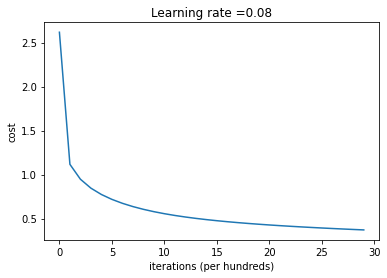

In [ ]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

Now, as a primitive hyperparameter choice setting, we check with different learing rates 0.1, 0.01 and 0.001. We can see that with higher learning rate both test and training error reduces. Likewise we can try with more number of iterations as well, although we need to be wary of the possible increase in bias.

learning rate is: 0.1
Cost after iteration 0: 1.479897
Cost after iteration 100: 0.873465
Cost after iteration 200: 0.746492
Cost after iteration 300: 0.673882
Cost after iteration 400: 0.623884
Cost after iteration 500: 0.586335
Cost after iteration 600: 0.556537
Cost after iteration 700: 0.532001
Cost after iteration 800: 0.511259
Cost after iteration 900: 0.493371
Cost after iteration 1000: 0.477701
Cost after iteration 1100: 0.463794
Cost after iteration 1200: 0.451317
Cost after iteration 1300: 0.440018
Cost after iteration 1400: 0.429701
Cost after iteration 1500: 0.420216
Cost after iteration 1600: 0.411441
Cost after iteration 1700: 0.403278
Cost after iteration 1800: 0.395648
Cost after iteration 1900: 0.388486
Cost after iteration 2000: 0.381737
Cost after iteration 2100: 0.375356
Cost after iteration 2200: 0.369304
Cost after iteration 2300: 0.363549
Cost after iteration 2400: 0.358062
Cost after iteration 2500: 0.352819
Cost after iteration 2600: 0.347798
Cost after iterati

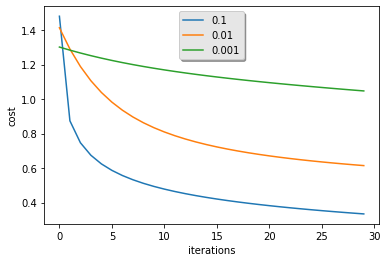

In [ ]:
learning_rates = [0.1, 0.01, 0.001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(X_train_flat, y_train_flat, X_test_flat, y_test_flat, num_iterations = 3000, learning_rate = i)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

## **Deep Neural Networks:**

Now, we will look into a deep neural network with many layers and hidden neurons. We will consider the number of layers and the neurons to be changeable. Except for the final layer, the neurons will have 'Relu' activation. The final layer will have one neuron with sigmoid activation.

First to initialize all the neurons, we consider the Xavier initialization. This initialization is weighted initialization normalized by the total number of neurons in the current and previous layer. This minimizes the problem faced by gradient descent algorithms of exploding and vanishing gradients, especially while considering a deep network.

In [ ]:
def initialize_deep(layer_dims):
  parameters = {}
  L = len(layer_dims)
  for l in range(1, L):
    parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/(layer_dims[l] + layer_dims[l-1]))
    parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
  return parameters

Unlike the previous case, here we separate the functions for forward propagation, cost computation and backward propagation.

The following function forward_propagate take the activation from previous layer (or input in the case of Layer 2) and outputs the activation depending on the type of function defined. Here, we also need cache of Z, A_prev, W and b for the backward propagation.

In [ ]:
def forward_propagate(W, b, A_prev, activation):
  Z = np.dot(W, A_prev) + b
  if activation == 'sigmoid':
    A = sigmoid(Z)
  elif activation == 'relu':
    A = np.maximum(Z, 0) 
  cache = Z, A_prev, W, b
  
  return A, cache

After passing through all the layers, we compute the cost, once again defined by the binary crossentropy function.

In [ ]:
def compute_cost(AL, y):
  m = y.shape[1]
  logprobs = np.multiply(np.log(AL),y) + np.multiply(np.log(1-AL),(1-y))
  cost = - np.sum(logprobs) / m      
  cost = np.squeeze(cost)
  return cost


Then the backpropagation step. With the current derivative with respect to the activation A (dA), we need to provide with the previous dA. This derivative of course depends on the activation function as well. Likewise after this computation, at every layer, we also compute the dW and db for that layer inorder to update the parameters. 

In [ ]:
def backpropagate(dA, cache, activation):
  Z, A, W, b = cache
  m = A.shape[1]
  
  if activation == "sigmoid":
    dZ = dA * (sigmoid(Z)*(1-sigmoid(Z)))
  else:
    dZ = np.array(dA, copy=True)
    dZ[Z<=0] = 0
  
  dA_prev = np.dot(W.T, dZ)
  dW = np.dot(dZ, A.T) * 1. / m 
  db = 1. / m * np.sum(dZ, axis=1, keepdims=True)

  return dA_prev, dW, db

Combining the forward propagation together, here, we have the forward propagation through all the layers. The first loop passes through relu activation L-1 times and as stated earlier, the final layer is passed through sigmoid activation. All the caches are present in the list caches for the backpropagation step. 

In [ ]:
def multilayer_propagate(X, parameters):
  caches = []
  A = X
  L = len(parameters) // 2

  for l in range(1, L):
      A_prev = A 
      A, cache = forward_propagate(parameters['W' + str(l)], parameters['b' + str(l)], A_prev, 'relu')
      caches.append(cache)
  
  AL, cache = forward_propagate(parameters['W' + str(L)], parameters['b' + str(L)], A, 'sigmoid')
  caches.append(cache)

  return AL, caches

After the forward propagation, we now have a function to compute the backpropagation step through all the layers. We start with the L-th layer with the sigmoid activation and then go through L-1 layers in the reversed manner, each time calculating dA_prev, dW and db.

In [ ]:
def multilayer_backpropagate(AL, y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    y = y.reshape(AL.shape)

    dAL = - (np.divide(y, AL) - np.divide(1 - y, 1 - AL))
    current_cache = caches[-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = backpropagate(dAL, current_cache, activation = "sigmoid")

    for l in reversed(range(L-1)):
      current_cache = caches[l]
      dA_prev_temp, dW_temp, db_temp = backpropagate(grads["dA" + str(l + 2)], current_cache, activation = "relu")
      grads["dA" + str(l + 1)] = dA_prev_temp
      grads["dW" + str(l + 1)] = dW_temp
      grads["db" + str(l + 1)] = db_temp

    return grads


After each iteration, we need to update the weights based on the derivative as a part of the gradient descent algorithm like in the previous scenario.

In [ ]:
def gradient_descent(parameters, grads, learning_rate):

  L = len(parameters) // 2
  for l in range(1,L+1):
        parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)] 
        parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)] 
  return parameters

We create global variables layers_dims to represent the total number of layers and the neurons in each layer. In the following example we consider 5 layers with the first layer being the input layer.

In [ ]:
layers_dims = [X_train_flat.shape[0], 5, 1]

In [ ]:
def multilayer_model(X, y, layers_dims, learning_rate = .08, num_iterations = 3000):
    costs = []                        
    parameters = initialize_deep(layers_dims)
    
    for i in range(0, num_iterations):
      AL, caches = multilayer_propagate(X, parameters)
      cost = compute_cost(AL, y)
      grads = multilayer_backpropagate(AL, y, caches)
      parameters = gradient_descent(parameters, grads, learning_rate)
      if i % 100 == 0:
        print ("Cost after iteration %i: %f" %(i, cost))
        costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.694106
Cost after iteration 100: 0.416637
Cost after iteration 200: 0.336061
Cost after iteration 300: 0.292344
Cost after iteration 400: 0.259212
Cost after iteration 500: 0.231365
Cost after iteration 600: 0.206932
Cost after iteration 700: 0.185088
Cost after iteration 800: 0.165428
Cost after iteration 900: 0.147744
Cost after iteration 1000: 0.131904
Cost after iteration 1100: 0.117763
Cost after iteration 1200: 0.105173
Cost after iteration 1300: 0.094024
Cost after iteration 1400: 0.084183
Cost after iteration 1500: 0.075510
Cost after iteration 1600: 0.067881
Cost after iteration 1700: 0.061176
Cost after iteration 1800: 0.055290
Cost after iteration 1900: 0.050122
Cost after iteration 2000: 0.045578
Cost after iteration 2100: 0.041578
Cost after iteration 2200: 0.038052
Cost after iteration 2300: 0.034936
Cost after iteration 2400: 0.032177
Cost after iteration 2500: 0.029727
Cost after iteration 2600: 0.027546
Cost after iteration 2700: 0.025597
Cost

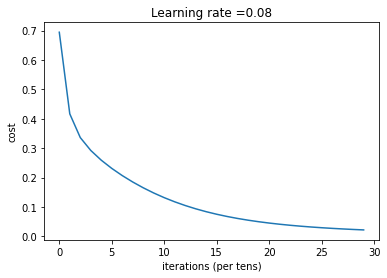

In [ ]:
parameters = multilayer_model(X_train_flat, y_train_flat, layers_dims, learning_rate = .08, num_iterations = 3000)


Now in order to calculate the accuracy, we have the following function predict_deep. We take the parameters resulting from the learning process and run training and test sets through it in order to gather the accuracy.

In [ ]:
def predict_deep(X, y, parameters):
  A = X
  L = len(parameters) // 2
  for l in range(1, L):
      A_prev = A 
      A, _ = forward_propagate(parameters['W' + str(l)], parameters['b' + str(l)], A_prev, 'relu')
  
  AL, _ = forward_propagate(parameters['W' + str(L)], parameters['b' + str(L)], A, 'sigmoid')
  Y_pred = (AL>=0.5).astype(int)

  return Y_pred

In [ ]:
  Y_pred_train_deep = predict_deep(X_train_flat, y_train_flat, parameters)
  Y_pred_test_deep = predict_deep(X_test_flat, y_test_flat, parameters)

  print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_train_deep - y_train_flat)) * 100))
  print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_test_deep- y_test_flat)) * 100))

train accuracy: 100.0 %
test accuracy: 89.8076923076923 %


As you can see, here the training accuracy is 100% whereas the test accuracy is 89 percent. This shows that the model is overfitting the data, so we need to reduce the variance from the data. We will see couple of techniques with which we can do this. We first perform dropout regularization and then L2 regularization.

## **Dropout Regularization**

The idea of dropout regularization is that we randomly drop few neurons in each layer (probabilistically), hence reducing the tendency to overfit the data. We define this probability for a neuron to stay in each layer in the list keep_prob. 

For each iteration, the dropped out neurons are different, obviously.

In [ ]:
keep_prob = [.5, .5, 1]

In the following function of forward propagation for a particular layer, we create a mask of 1s and 0s according to the mentioned probabilities. This mask zeros the activation from the dropped out neuron.

In [ ]:
def forward_propagate_dropout(W, b, A_prev, activation, keep_prob):
  D = np.random.rand(A_prev.shape[0], A_prev.shape[1]) <= keep_prob
  A_prev = A_prev*D
  A_prev = A_prev/keep_prob
  Z = np.dot(W, A_prev) + b
  if activation == 'sigmoid':
    A = sigmoid(Z)
  elif activation == 'relu':
    A = np.maximum(Z, 0) 
  cache = Z, A_prev, W, b
  
  return A, cache

In [ ]:
def multilayer_propagate_dropout(X, parameters, keep_prob):
  caches = []
  A = X
  L = len(parameters) // 2

  for l in range(1, L):
      A_prev = A 
      A, cache = forward_propagate_dropout(parameters['W' + str(l)], parameters['b' + str(l)], A_prev, 'relu', keep_prob[l])
      caches.append(cache)
  
  AL, cache = forward_propagate(parameters['W' + str(L)], parameters['b' + str(L)], A, 'sigmoid')
  caches.append(cache)

  return AL, caches

In [ ]:
def multilayer_model_dropout(X, y, layers_dims, keep_prob, learning_rate = .1, num_iterations = 3000):
    costs = []                        
    parameters = initialize_deep(layers_dims)
    
    for i in range(0, num_iterations):
      AL, caches = multilayer_propagate_dropout(X, parameters, keep_prob)
      cost = compute_cost(AL, y)
      grads = multilayer_backpropagate(AL, y, caches)
      parameters = gradient_descent(parameters, grads, learning_rate)
      if i % 100 == 0:
        print ("Cost after iteration %i: %f" %(i, cost))
        costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.701595
Cost after iteration 100: 0.512466
Cost after iteration 200: 0.482611
Cost after iteration 300: 0.431478
Cost after iteration 400: 0.406112
Cost after iteration 500: 0.370961
Cost after iteration 600: 0.342294
Cost after iteration 700: 0.341484
Cost after iteration 800: 0.326051
Cost after iteration 900: 0.288006
Cost after iteration 1000: 0.279980
Cost after iteration 1100: 0.282799
Cost after iteration 1200: 0.259769
Cost after iteration 1300: 0.246019
Cost after iteration 1400: 0.246960
Cost after iteration 1500: 0.245484
Cost after iteration 1600: 0.210063
Cost after iteration 1700: 0.215678
Cost after iteration 1800: 0.217417
Cost after iteration 1900: 0.181492
Cost after iteration 2000: 0.188799
Cost after iteration 2100: 0.183390
Cost after iteration 2200: 0.184585
Cost after iteration 2300: 0.177489
Cost after iteration 2400: 0.192915
Cost after iteration 2500: 0.162572
Cost after iteration 2600: 0.148734
Cost after iteration 2700: 0.162780
Cost

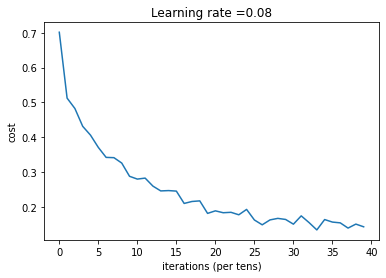

In [ ]:
parameters_dropout = multilayer_model_dropout(X_train_flat, y_train_flat, layers_dims, keep_prob, learning_rate = .08, num_iterations = 4000)

In [ ]:
  Y_pred_train_deep = predict_deep(X_train_flat, y_train_flat, parameters_dropout)
  Y_pred_test_deep = predict_deep(X_test_flat, y_test_flat, parameters_dropout)

  print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_train_deep - y_train_flat)) * 100))
  print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_test_deep- y_test_flat)) * 100))

train accuracy: 100.0 %
test accuracy: 90.1923076923077 %


After dropout we see that the test accuracy increases to 90%.

### **L2 Regularization**

In [ ]:
def compute_cost_L2(AL, y, layers_dims, lambd):
  m = y.shape[1]
  L = len(layers_dims)
  logprobs = np.multiply(np.log(AL),y) + np.multiply(np.log(1-AL),1-y)
  regularization = 0
  for l in range(1, L):
    regularization += np.linalg.norm(parameters['W' + str(l)], ord = 'fro') 
  regularization*=lambd/(2*m)
  cost = - np.sum(logprobs) / m      
  cost = np.squeeze(cost)+regularization
  return cost


In [ ]:
def gradient_descent_L2(parameters, grads, learning_rate, lambd):
  m = parameters["W1"].shape[1]
  L = len(parameters) // 2
  for l in range(1,L+1):
        parameters["W" + str(l)] -= learning_rate * (grads["dW" + str(l)] + lambd/(2*m)* parameters["W" + str(l)])
        parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)] 
  return parameters

In [ ]:
def multilayer_model_L2(X, y, layers_dims, keep_prob, learning_rate = .1, num_iterations = 3000, lambd = .5):
    costs = []                        
    parameters = initialize_deep(layers_dims)
    
    for i in range(0, num_iterations):
      AL, caches = multilayer_propagate(X, parameters)
      cost = compute_cost_L2(AL, y, layers_dims, lambd)
      grads = multilayer_backpropagate(AL, y, caches)
      parameters = gradient_descent_L2(parameters, grads, learning_rate, lambd)
      if i % 100 == 0:
        print ("Cost after iteration %i: %f" %(i, cost))
        costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.697443
Cost after iteration 100: 0.434456
Cost after iteration 200: 0.340220
Cost after iteration 300: 0.296630
Cost after iteration 400: 0.264868
Cost after iteration 500: 0.238386
Cost after iteration 600: 0.215244
Cost after iteration 700: 0.194515
Cost after iteration 800: 0.175752
Cost after iteration 900: 0.158772
Cost after iteration 1000: 0.143470
Cost after iteration 1100: 0.129758
Cost after iteration 1200: 0.117471
Cost after iteration 1300: 0.106446
Cost after iteration 1400: 0.096576
Cost after iteration 1500: 0.087755
Cost after iteration 1600: 0.079886
Cost after iteration 1700: 0.072855
Cost after iteration 1800: 0.066566
Cost after iteration 1900: 0.060941
Cost after iteration 2000: 0.055937
Cost after iteration 2100: 0.051475
Cost after iteration 2200: 0.047491
Cost after iteration 2300: 0.043935
Cost after iteration 2400: 0.040742
Cost after iteration 2500: 0.037940
Cost after iteration 2600: 0.035481
Cost after iteration 2700: 0.033287
Cost

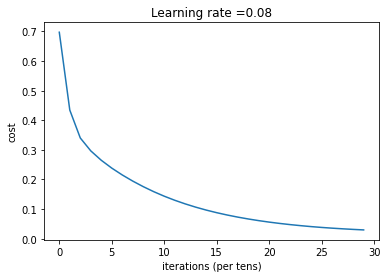

In [ ]:
parameters_L2 = multilayer_model_L2(X_train_flat, y_train_flat, layers_dims, keep_prob, learning_rate = .08, num_iterations = 3000, lambd = .5)

In [ ]:
  Y_pred_train_deep = predict_deep(X_train_flat, y_train_flat, parameters_L2)
  Y_pred_test_deep = predict_deep(X_test_flat, y_test_flat, parameters_L2)

  print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_train_deep - y_train_flat)) * 100))
  print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_test_deep- y_test_flat)) * 100))

train accuracy: 99.83498349834983 %
test accuracy: 89.61538461538461 %


## **Dropout + L2 regularization:**

In [ ]:
def multilayer_model_regularized(X, y, layers_dims, keep_prob, learning_rate = .1, num_iterations = 3000, lambd = .5):
    costs = []                        
    parameters = initialize_deep(layers_dims)
    
    for i in range(0, num_iterations):
      AL, caches = multilayer_propagate_dropout(X, parameters, keep_prob)
      cost = compute_cost_L2(AL, y, layers_dims, lambd)
      grads = multilayer_backpropagate(AL, y, caches)
      parameters = gradient_descent_L2(parameters, grads, learning_rate, lambd)
      if i % 100 == 0:
        print ("Cost after iteration %i: %f" %(i, cost))
        costs.append(cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.701359
Cost after iteration 100: 0.566392
Cost after iteration 200: 0.484533
Cost after iteration 300: 0.462656
Cost after iteration 400: 0.425634
Cost after iteration 500: 0.392194
Cost after iteration 600: 0.360535
Cost after iteration 700: 0.345067
Cost after iteration 800: 0.317664
Cost after iteration 900: 0.316867
Cost after iteration 1000: 0.300786
Cost after iteration 1100: 0.289479
Cost after iteration 1200: 0.278205
Cost after iteration 1300: 0.263274
Cost after iteration 1400: 0.249577
Cost after iteration 1500: 0.240018
Cost after iteration 1600: 0.233365
Cost after iteration 1700: 0.224009
Cost after iteration 1800: 0.218788
Cost after iteration 1900: 0.220039
Cost after iteration 2000: 0.204732
Cost after iteration 2100: 0.201018
Cost after iteration 2200: 0.190404
Cost after iteration 2300: 0.185850
Cost after iteration 2400: 0.181472
Cost after iteration 2500: 0.194417
Cost after iteration 2600: 0.192336
Cost after iteration 2700: 0.195587
Cost

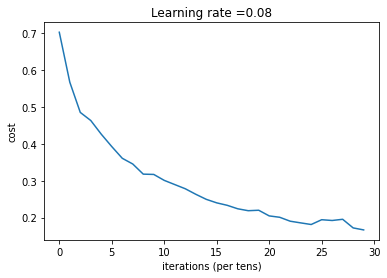

In [ ]:
parameters_regularized = multilayer_model_regularized(X_train_flat, y_train_flat, layers_dims, keep_prob, learning_rate = .08, num_iterations = 3000, lambd = .5)

In [ ]:
  Y_pred_train_deep = predict_deep(X_train_flat, y_train_flat, parameters_regularized)
  Y_pred_test_deep = predict_deep(X_test_flat, y_test_flat, parameters_regularized)

  print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_train_deep - y_train_flat)) * 100))
  print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_test_deep- y_test_flat)) * 100))

train accuracy: 99.91749174917491 %
test accuracy: 91.34615384615384 %


As you can see the L2 regularization + droput increases the test accuracy to 91%.

## **Conclusion:**

In conclusion, in this project we tackled the classification problem for fake or real job advertisements. We started with a simple logistic regression model in the flavour of deep learning and then continued on to build a multiple layers neural network. We also saw how to increase regularization to reduce the variance present in the data. With regularization, we were able to achieve an accuracy of 91%.